# Flight Status Predictor

**What problem are we trying to solve?**

The goal of this project is to **develop and deploy an ML model** in which an end user can specify a set of features describing a commercial flight of interest and receive a categorical (yes or no) output indicating if the arrival time of that flight will be delayed more than fifteen minutes or not. 

**Model is ready to be deployed as a pkl file**

In [3]:
# Import libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from joblib import dump
%matplotlib inline

In [5]:
# Store CSV file in variable 
flights = r'..\data\DF_from_Feature_Sel_for_Model_Sel.csv'
# Read CSV file in pandas dataframe 
df = pd.read_csv(flights)

In [7]:
# Print dataframe to confirm successful loading
df

,Carrier_Name,Week_Day,Flight_Date,Flight_Number,Origin_City_State,Destination_City_State,Dep_Time_Block_Group,Scheduled_Departure_Time,Scheduled_Arrival_Time,Scheduled_Gate_to_Gate_Time,Distance_Miles,Distance_Group,delayed
0,United Air Lines Inc.,Tuesday,2023-09-05,773,"Denver, CO","Nashville, TN",Afternoon,1743,2119,156,1014,5,0
1,Delta Air Lines Inc.,Friday,2024-03-29,2641,"Salt Lake City, UT","Seattle, WA",Afternoon,1710,1823,133,689,3,0
2,American Airlines Inc.,Sunday,2023-06-04,2677,"Orlando, FL","Dallas/Fort Worth, TX",Early Morning,550,745,175,985,4,0
3,Delta Air Lines Inc.,Friday,2023-08-04,1451,"Jacksonville, FL","Boston, MA",Early Afternoon,1215,1459,164,1010,5,1
4,Southwest Airlines Co.,Tuesday,2023-04-18,185,"Dallas, TX","Indianapolis, IN",Evening,1955,2255,120,755,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,Thursday,2023-10-26,4815,"Dallas/Fort Worth, TX","Killeen, TX",Morning,1044,1202,78,134,1,1
2742898,Southwest Airlines Co.,Thursday,2023-07-20,4277,"Las Vegas, NV","El Paso, TX",Afternoon,1620,1905,105,583,3,1
2742899,Endeavor Air Inc.,Saturday,2024-01-27,4915,"Des Moines, IA","New York, NY",Early Afternoon,1300,1644,164,1031,5,0
2742900,Southwest Airlines Co.,Thursday,2023-07-20,1817,"Phoenix, AZ","St. Louis, MO",Evening,2015,115,180,1262,6,1


In [9]:
df.columns

Index(['Carrier_Name', 'Week_Day', 'Flight_Date', 'Flight_Number',
       'Origin_City_State', 'Destination_City_State', 'Dep_Time_Block_Group',
       'Scheduled_Departure_Time', 'Scheduled_Arrival_Time',
       'Scheduled_Gate_to_Gate_Time', 'Distance_Miles', 'Distance_Group',
       'delayed'],
      dtype='object')

# Data Preprocessing (Data Cleaning and Preparation)

<span style="color:red">**NOTE**</span>: This step was mostly taken care of during EDA, Feature Selection Model Selection, and Model Creation but wanted to still view the data and make any necessary adjustments

**Get Summary of dataset**

In [14]:
# Get summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 13 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   Carrier_Name                 object
 1   Week_Day                     object
 2   Flight_Date                  object
 3   Flight_Number                int64 
 4   Origin_City_State            object
 5   Destination_City_State       object
 6   Dep_Time_Block_Group         object
 7   Scheduled_Departure_Time     int64 
 8   Scheduled_Arrival_Time       int64 
 9   Scheduled_Gate_to_Gate_Time  int64 
 10  Distance_Miles               int64 
 11  Distance_Group               int64 
 12  delayed                      int64 
dtypes: int64(7), object(6)
memory usage: 272.0+ MB


Columns that need to be converted to Object dtype: 
- Flight_Number

Holding off on converting since some columns will not be needed for analysis

Let us move on to checking for **NULL** and **Duplicate** values 

In [18]:
# Check for missing values 
print(df.isnull().sum())

Carrier_Name                   0
Week_Day                       0
Flight_Date                    0
Flight_Number                  0
Origin_City_State              0
Destination_City_State         0
Dep_Time_Block_Group           0
Scheduled_Departure_Time       0
Scheduled_Arrival_Time         0
Scheduled_Gate_to_Gate_Time    0
Distance_Miles                 0
Distance_Group                 0
delayed                        0
dtype: int64


In [20]:
# Check for duplicate entries
df[df.duplicated()]

,Carrier_Name,Week_Day,Flight_Date,Flight_Number,Origin_City_State,Destination_City_State,Dep_Time_Block_Group,Scheduled_Departure_Time,Scheduled_Arrival_Time,Scheduled_Gate_to_Gate_Time,Distance_Miles,Distance_Group,delayed


As stated before during EDA and Feature Selection, there doesn't appear to be any duplicated rows

Remember, during EDA, we already renamed the target variable column **Arr_Delay_At_Least_15_Minutes** to **delayed**

In [26]:
df.columns

Index(['Carrier_Name', 'Week_Day', 'Flight_Date', 'Flight_Number',
       'Origin_City_State', 'Destination_City_State', 'Dep_Time_Block_Group',
       'Scheduled_Departure_Time', 'Scheduled_Arrival_Time',
       'Scheduled_Gate_to_Gate_Time', 'Distance_Miles', 'Distance_Group',
       'delayed'],
      dtype='object')

# Feature Selection

Based off the information gathered in Feature Selection using the Phik Coreelation Matrix, the following features will be used to deploy the model: 

> Categorical Variables:
> - Carrier_Name
> - Dep_Time_Block_Group
> - Flight_Date (Month) - Will need to convert this to actual month (Jan, Feb, Mar, etc.) to avoid ordinality with numbers
>
> Numeric Variables:
> - Scheduled_Arrival_Time
> - Scheduled_Departure_Time
> - Flight_Date (Year)
> - Flight_Date (Day)
> - delayed (target variable)

In [30]:
# Add highly correlated features into a new dataframe 
df_features = pd.DataFrame(data=df[['Carrier_Name', 'Flight_Date', 'Dep_Time_Block_Group', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'delayed']])
df_features

,Carrier_Name,Flight_Date,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed
0,United Air Lines Inc.,2023-09-05,Afternoon,2119,1743,0
1,Delta Air Lines Inc.,2024-03-29,Afternoon,1823,1710,0
2,American Airlines Inc.,2023-06-04,Early Morning,745,550,0
3,Delta Air Lines Inc.,2023-08-04,Early Afternoon,1459,1215,1
4,Southwest Airlines Co.,2023-04-18,Evening,2255,1955,1
...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,2023-10-26,Morning,1202,1044,1
2742898,Southwest Airlines Co.,2023-07-20,Afternoon,1905,1620,1
2742899,Endeavor Air Inc.,2024-01-27,Early Afternoon,1644,1300,0
2742900,Southwest Airlines Co.,2023-07-20,Evening,115,2015,1


In [32]:
# Convert 'Flight_Date' to datetime objects
df_features['Flight_Date'] = pd.to_datetime(df_features['Flight_Date'])

# Extract month and year
df_features['Month'] = df_features['Flight_Date'].dt.month
df_features['Year'] = df_features['Flight_Date'].dt.year
df_features['Day'] = df_features['Flight_Date'].dt.day

In [34]:
df_features

,Carrier_Name,Flight_Date,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed,Month,Year,Day
0,United Air Lines Inc.,2023-09-05,Afternoon,2119,1743,0,9,2023,5
1,Delta Air Lines Inc.,2024-03-29,Afternoon,1823,1710,0,3,2024,29
2,American Airlines Inc.,2023-06-04,Early Morning,745,550,0,6,2023,4
3,Delta Air Lines Inc.,2023-08-04,Early Afternoon,1459,1215,1,8,2023,4
4,Southwest Airlines Co.,2023-04-18,Evening,2255,1955,1,4,2023,18
...,...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,2023-10-26,Morning,1202,1044,1,10,2023,26
2742898,Southwest Airlines Co.,2023-07-20,Afternoon,1905,1620,1,7,2023,20
2742899,Endeavor Air Inc.,2024-01-27,Early Afternoon,1644,1300,0,1,2024,27
2742900,Southwest Airlines Co.,2023-07-20,Evening,115,2015,1,7,2023,20


In [36]:
# Convert Month to actual month (Jan, Feb, Mar, etc.)
df_features['Month'] = pd.to_datetime(df_features['Month'], format="%m").dt.strftime("%b")

In [38]:
df_features

,Carrier_Name,Flight_Date,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed,Month,Year,Day
0,United Air Lines Inc.,2023-09-05,Afternoon,2119,1743,0,Sep,2023,5
1,Delta Air Lines Inc.,2024-03-29,Afternoon,1823,1710,0,Mar,2024,29
2,American Airlines Inc.,2023-06-04,Early Morning,745,550,0,Jun,2023,4
3,Delta Air Lines Inc.,2023-08-04,Early Afternoon,1459,1215,1,Aug,2023,4
4,Southwest Airlines Co.,2023-04-18,Evening,2255,1955,1,Apr,2023,18
...,...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,2023-10-26,Morning,1202,1044,1,Oct,2023,26
2742898,Southwest Airlines Co.,2023-07-20,Afternoon,1905,1620,1,Jul,2023,20
2742899,Endeavor Air Inc.,2024-01-27,Early Afternoon,1644,1300,0,Jan,2024,27
2742900,Southwest Airlines Co.,2023-07-20,Evening,115,2015,1,Jul,2023,20


In [40]:
# Drop unnecessary columns from new dataframe 
df_features.drop(['Flight_Date'], axis=1, inplace=True)

In [42]:
df_features

,Carrier_Name,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed,Month,Year,Day
0,United Air Lines Inc.,Afternoon,2119,1743,0,Sep,2023,5
1,Delta Air Lines Inc.,Afternoon,1823,1710,0,Mar,2024,29
2,American Airlines Inc.,Early Morning,745,550,0,Jun,2023,4
3,Delta Air Lines Inc.,Early Afternoon,1459,1215,1,Aug,2023,4
4,Southwest Airlines Co.,Evening,2255,1955,1,Apr,2023,18
...,...,...,...,...,...,...,...,...
2742897,SkyWest Airlines Inc.,Morning,1202,1044,1,Oct,2023,26
2742898,Southwest Airlines Co.,Afternoon,1905,1620,1,Jul,2023,20
2742899,Endeavor Air Inc.,Early Afternoon,1644,1300,0,Jan,2024,27
2742900,Southwest Airlines Co.,Evening,115,2015,1,Jul,2023,20


In [44]:
# Check for missing values 
print(df_features.isnull().sum())

Carrier_Name                0
Dep_Time_Block_Group        0
Scheduled_Arrival_Time      0
Scheduled_Departure_Time    0
delayed                     0
Month                       0
Year                        0
Day                         0
dtype: int64


In [46]:
# Grouping numerical columns and
# Moving the target variable to be the right-most column

# Columns to move
cols_to_move = [
                'Carrier_Name',
                'Dep_Time_Block_Group',
                'Month',
                'Year',
                'Day',
                'Scheduled_Arrival_Time', 
                'Scheduled_Departure_Time'
                ]

last_col = 'delayed'

# Extracting the columns to move
columns_to_move = df_features[cols_to_move]

# Dropping these columns from the DataFrame
df_features.drop(columns=cols_to_move, inplace=True)

# Extracting the last column
last_column = df_features.pop(last_col)

# Reinserting the numerical columns
df_features = pd.concat([df_features, columns_to_move], axis=1)

# Reinserting the last column
df_features[last_col] = last_column

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 8 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Carrier_Name              object
 1   Dep_Time_Block_Group      object
 2   Month                     object
 3   Year                      int32 
 4   Day                       int32 
 5   Scheduled_Arrival_Time    int64 
 6   Scheduled_Departure_Time  int64 
 7   delayed                   int64 
dtypes: int32(2), int64(3), object(3)
memory usage: 146.5+ MB


In [48]:
# Define categorical and numerical features
categorical_features = ['Carrier_Name', 'Dep_Time_Block_Group', 'Month']
numerical_features = ['Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Year', 'Day']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Redefine X (features) and y (target) variables
X = df_features[['Carrier_Name', 'Year', 'Month', 'Day', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 
                'Dep_Time_Block_Group']]
y = df_features["delayed"]

# Apply the preprocessing pipeline to X
x_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_preprocessed, y, test_size=0.2, random_state=42)

print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2194321, 37)
x_test shape: (548581, 37)
y_train shape: (2194321,)
y_test shape: (548581,)


---

# Model Creation: Logistic Regression

In [52]:
# Logistic regression model
logreg = LogisticRegression(random_state=42)

# Train and evaluate the model
logreg.fit(X_train, y_train)
# Predictions on test data
y_pred = logreg.predict(X_test)

## Initial Model Performance

In [55]:
# Calculate confusion matrix
cm_init = confusion_matrix(y_test, y_pred)

# Calculate precision and recall
precision_init, recall_init, _ = precision_recall_curve(y_test, y_pred)

# Calculate ROC curve
fpr_init, tpr_init, _ = roc_curve(y_test, y_pred)

# Calculate ROC AUC score
roc_auc_init = roc_auc_score(y_test, y_pred)

# Calculate evaluation metrics
accuracy_init = accuracy_score(y_test, y_pred)
f1_init= f1_score(y_test, y_pred)

Confusion Matrix:
 [[164918 109501]
 [ 99262 174900]]

True Positives(TP) =  164918

True Negatives(TN) =  174900

False Positives(FP) =  109501

False Negatives(FN) =  99262

Accuracy: 0.6194490877372713
F1 Score: 0.6262498590132178
ROC AUC Score: 0.6194577481975653
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61    274419
           1       0.61      0.64      0.63    274162

    accuracy                           0.62    548581
   macro avg       0.62      0.62      0.62    548581
weighted avg       0.62      0.62      0.62    548581



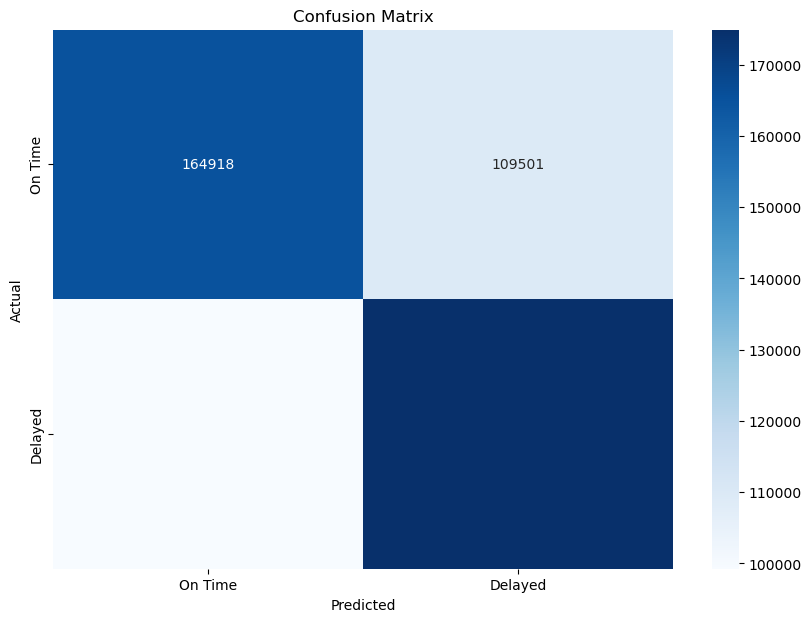

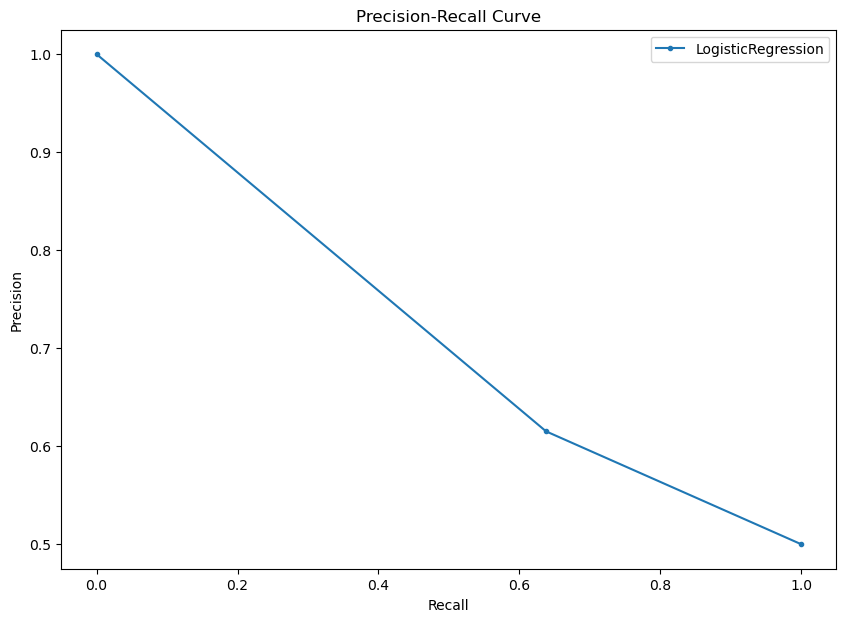

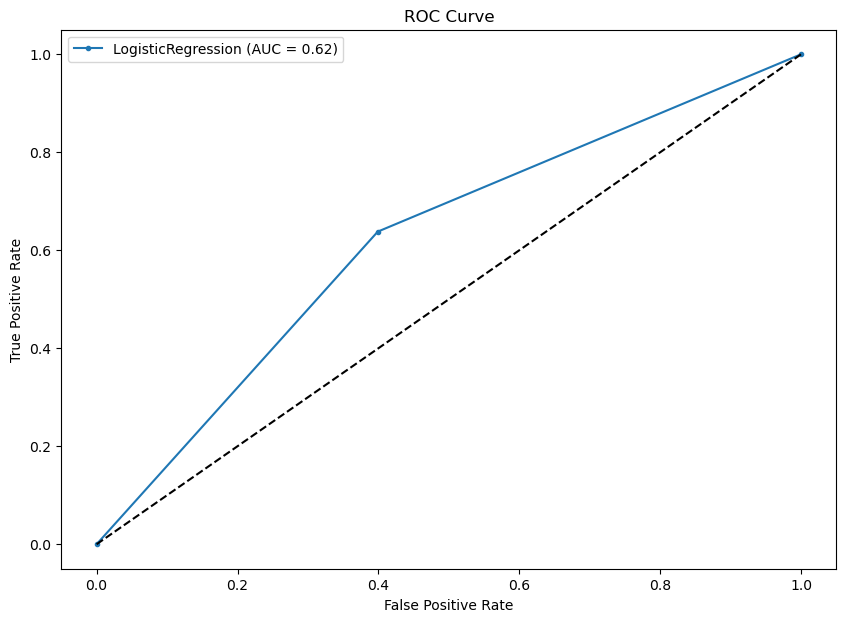

In [57]:
# Display metrics
print("Confusion Matrix:\n", cm_init)
print('\nTrue Positives(TP) = ', cm_init[0,0])
print('\nTrue Negatives(TN) = ', cm_init[1,1])
print('\nFalse Positives(FP) = ', cm_init[0,1])
print('\nFalse Negatives(FN) = ', cm_init[1,0])
print("\nAccuracy:", accuracy_init)
print("F1 Score:", f1_init)
print("ROC AUC Score:", roc_auc_init)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_init, annot=True, fmt='d', cmap='Blues', xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall_init, precision_init, marker='.', label='LogisticRegression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_init, tpr_init, marker='.', label='LogisticRegression (AUC = %0.2f)' % roc_auc_init)
plt.plot([0,1], [0,1], 'k--' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Key Observations 
- The model has an accuracy of **61.94%**, meaning it correctly classifies approximately **62%** of the instances
- The F1 score, which balances precision and recall, is approximately **62.62%**, indicating a moderate performance
- The ROC AUC score is about **61.95%**, suggesting that the model is somewhat capable of distinguishing between the two classes, but there's room for improvement
- The classification report indicates similar performance for both classes, with precision, recall, and F1 scores around **60-64%**

Overall, while the model shows some ability to classify the data, its performance metrics suggest that there is considerable room for improvement

## K-Folds Cross Validation

This will ensure we did not get lucky with the test set, relieving of any bias in the data as it performs many iterations of the training set

In [63]:
# Defining k-Folds Cross Validation parameters
accuracies = cross_val_score(estimator = logreg,
                    X = x_preprocessed,
                    y = y,
                    scoring = 'accuracy',
                    cv = 10)

print("Accuracy: {:.3f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.3f}".format(accuracies.std()))

Accuracy: 62.014 %
Standard Deviation: 0.000


**Accuracy**: The accuracy **62.014%** suggests that the model is correctly predicting the target variable approximately **62.0%** of the time. This accuracy will serve as a baseline to gauge improvement after hyperparameter tuning 

**Standard Deviation**: The standard deviation of **0.000 (or 0%)** indicates that the accuracy across different folds is consistent, suggesting that the model's performance is stable across the dataset split

## Hyperparameter Tuning

In [73]:
# Define the parameter grid for hyperparameter tuning
# Valid parameters for logistic regression: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio',
#                                            'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 
#                                            'tol', 'verbose', 'warm_start'].
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]  # Increase max_iter for 'lbfgs'
}
# Perform hyperparameter tuning using GridSearchCV
lr = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model
best_lr = grid_search.best_estimator_

# Print the best hyperparameters
print(grid_search.best_params_)

# Evaluate the best model
y_pred = best_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix of best model:')
print(cm)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Confusion Matrix of best model:
[[164601 109818]
 [ 98999 175163]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61    274419
           1       0.61      0.64      0.63    274162

    accuracy                           0.62    548581
   macro avg       0.62      0.62      0.62    548581
weighted avg       0.62      0.62      0.62    548581



## Model Optimization

In [76]:
# Initialize a logistic regression model with the best hyperparameters
best_params = {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
best_model = LogisticRegression(**best_params)

# Train the optimized model on the training data
best_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')

## Model Evaluation

In [79]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Generate classification report and confusion matrix (optional)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.619445441967549
Precision: 0.6149780758046197
Recall: 0.6379184569706962
F1-score: 0.6262382486111384

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61    274419
           1       0.61      0.64      0.63    274162

    accuracy                           0.62    548581
   macro avg       0.62      0.62      0.62    548581
weighted avg       0.62      0.62      0.62    548581


Confusion Matrix:
[[164923 109496]
 [ 99269 174893]]


---

# Save model in pkl file to be used in a web app

In [83]:
# Define categorical and numerical features
categorical_features = ['Carrier_Name', 'Dep_Time_Block_Group', 'Month']
numerical_features = ['Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Year', 'Day']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Redefine X (features) and y (target) variables
X = df_features[['Carrier_Name', 'Year', 'Month', 'Day', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 
                'Dep_Time_Block_Group']]
y = df_features["delayed"]

# Apply the preprocessing pipeline to X
x_preprocessed = preprocessor.fit_transform(X)

In [85]:
# Split the data into training+validation and test sets (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(x_preprocessed, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets (75% train, 25% val of train_val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f'x_train_val shape: {X_train_val.shape}')
print(f'x_test shape: {X_test.shape}')
print(f'y_train_val shape: {y_train_val.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'x_train shape: {X_train.shape}')
print(f'x_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

x_train_val shape: (2194321, 37)
x_test shape: (548581, 37)
y_train_val shape: (2194321,)
y_test shape: (548581,)
x_train shape: (1645740, 37)
x_val shape: (548581, 37)
y_train shape: (1645740,)
y_val shape: (548581,)


In [87]:
# Logistic regression model
logreg = LogisticRegression(random_state=42)

# Train and evaluate the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [89]:
# Predict on the validation set and calculate classification report
y_val_pred = logreg.predict(X_val)
val_report = classification_report(y_val, y_val_pred)
print(val_report)

# Predict on the test set and calculate classification report
y_test_pred = logreg.predict(X_test)
test_report = classification_report(y_test, y_test_pred)
print(test_report)

              precision    recall  f1-score   support

           0       0.62      0.60      0.61    274289
           1       0.62      0.64      0.63    274292

    accuracy                           0.62    548581
   macro avg       0.62      0.62      0.62    548581
weighted avg       0.62      0.62      0.62    548581

              precision    recall  f1-score   support

           0       0.62      0.60      0.61    274419
           1       0.62      0.64      0.63    274162

    accuracy                           0.62    548581
   macro avg       0.62      0.62      0.62    548581
weighted avg       0.62      0.62      0.62    548581



In [91]:
# save model
dump(logreg, 'Model_Deploy_Olivia/models/flight_model.pkl')

['Model_Deploy_Olivia/models/flight_model.pkl']

## Web App Data Needed

In [94]:
df_features.head(5)

,Carrier_Name,Dep_Time_Block_Group,Month,Year,Day,Scheduled_Arrival_Time,Scheduled_Departure_Time,delayed
0,United Air Lines Inc.,Afternoon,Sep,2023,5,2119,1743,0
1,Delta Air Lines Inc.,Afternoon,Mar,2024,29,1823,1710,0
2,American Airlines Inc.,Early Morning,Jun,2023,4,745,550,0
3,Delta Air Lines Inc.,Early Afternoon,Aug,2023,4,1459,1215,1
4,Southwest Airlines Co.,Evening,Apr,2023,18,2255,1955,1


In [98]:
df_webapp = pd.DataFrame(data=df_features[['Carrier_Name', 'Dep_Time_Block_Group', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time']])
df_webapp

,Carrier_Name,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time
0,United Air Lines Inc.,Afternoon,2119,1743
1,Delta Air Lines Inc.,Afternoon,1823,1710
2,American Airlines Inc.,Early Morning,745,550
3,Delta Air Lines Inc.,Early Afternoon,1459,1215
4,Southwest Airlines Co.,Evening,2255,1955
...,...,...,...,...
2742897,SkyWest Airlines Inc.,Morning,1202,1044
2742898,Southwest Airlines Co.,Afternoon,1905,1620
2742899,Endeavor Air Inc.,Early Afternoon,1644,1300
2742900,Southwest Airlines Co.,Evening,115,2015


In [102]:
df_webapp['Carrier_Name'].unique()

array(['United Air Lines Inc.', 'Delta Air Lines Inc.',
       'American Airlines Inc.', 'Southwest Airlines Co.',
       'Allegiant Air', 'JetBlue Airways', 'PSA Airlines Inc.',
       'Endeavor Air Inc.', 'Alaska Airlines Inc.',
       'Frontier Airlines Inc.', 'Envoy Air', 'Hawaiian Airlines Inc.',
       'SkyWest Airlines Inc.', 'Republic Airline', 'Spirit Air Lines'],
      dtype=object)

In [118]:
df_webapp['Dep_Time_Block_Group'].unique()

array(['Afternoon', 'Early Morning', 'Early Afternoon', 'Evening',
       'Morning', 'Night'], dtype=object)

### Scheduled_Departure_Time

In [100]:
df_webapp['Scheduled_Departure_Time'].nunique()

1353

In [112]:
df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'United Air Lines Inc.')]

,Carrier_Name,Dep_Time_Block_Group,Scheduled_Arrival_Time,Scheduled_Departure_Time
86,United Air Lines Inc.,Early Morning,930,629
181,United Air Lines Inc.,Early Morning,1602,730
192,United Air Lines Inc.,Early Morning,1330,752
235,United Air Lines Inc.,Early Morning,841,500
238,United Air Lines Inc.,Early Morning,837,530
...,...,...,...,...
2742579,United Air Lines Inc.,Early Morning,759,602
2742590,United Air Lines Inc.,Early Morning,853,600
2742640,United Air Lines Inc.,Early Morning,925,735
2742731,United Air Lines Inc.,Early Morning,953,750


In [122]:
# United Air Lines Inc.
unitedEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'United Air Lines Inc.'), 'Scheduled_Departure_Time']
unitedMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'United Air Lines Inc.'), 'Scheduled_Departure_Time']
unitedEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'United Air Lines Inc.'), 'Scheduled_Departure_Time']
unitedAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'United Air Lines Inc.'), 'Scheduled_Departure_Time']
unitedEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'United Air Lines Inc.'), 'Scheduled_Departure_Time']
unitedNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'United Air Lines Inc.'), 'Scheduled_Departure_Time']

# Delta Air Lines Inc.
deltaEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Delta Air Lines Inc.'), 'Scheduled_Departure_Time']
deltaMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Delta Air Lines Inc.'), 'Scheduled_Departure_Time']
deltaEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Delta Air Lines Inc.'), 'Scheduled_Departure_Time']
deltaAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Delta Air Lines Inc.'), 'Scheduled_Departure_Time']
deltaEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Delta Air Lines Inc.'), 'Scheduled_Departure_Time']
deltaNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Delta Air Lines Inc.'), 'Scheduled_Departure_Time']

# American Airlines Inc.
americanEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'American Airlines Inc.'), 'Scheduled_Departure_Time']
americanMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'American Airlines Inc.'), 'Scheduled_Departure_Time']
americanEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'American Airlines Inc.'), 'Scheduled_Departure_Time']
americanAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'American Airlines Inc.'), 'Scheduled_Departure_Time']
americanEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'American Airlines Inc.'), 'Scheduled_Departure_Time']
americanNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'American Airlines Inc.'), 'Scheduled_Departure_Time']

# Southwest Airlines Co.
southwestEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Southwest Airlines Co.'), 'Scheduled_Departure_Time']
southwestMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Southwest Airlines Co.'), 'Scheduled_Departure_Time']
southwestEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Southwest Airlines Co.'), 'Scheduled_Departure_Time']
southwestAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Southwest Airlines Co.'), 'Scheduled_Departure_Time']
southwestEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Southwest Airlines Co.'), 'Scheduled_Departure_Time']
southwestNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Southwest Airlines Co.'), 'Scheduled_Departure_Time']

# Allegiant Air
allegiantEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Allegiant Air'), 'Scheduled_Departure_Time']
allegiantMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Allegiant Air'), 'Scheduled_Departure_Time']
allegiantEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Allegiant Air'), 'Scheduled_Departure_Time']
allegiantAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Allegiant Air'), 'Scheduled_Departure_Time']
allegiantEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Allegiant Air'), 'Scheduled_Departure_Time']
allegiantNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Allegiant Air'), 'Scheduled_Departure_Time']

# JetBlue Airways
jetblueEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'JetBlue Airways'), 'Scheduled_Departure_Time']
jetblueMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'JetBlue Airways'), 'Scheduled_Departure_Time']
jetblueEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'JetBlue Airways'), 'Scheduled_Departure_Time']
jetblueAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'JetBlue Airways'), 'Scheduled_Departure_Time']
jetblueEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'JetBlue Airways'), 'Scheduled_Departure_Time']
jetblueNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'JetBlue Airways'), 'Scheduled_Departure_Time']

# PSA Airlines Inc.
psaEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'PSA Airlines Inc.'), 'Scheduled_Departure_Time']
psaMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'PSA Airlines Inc.'), 'Scheduled_Departure_Time']
psaEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'PSA Airlines Inc.'), 'Scheduled_Departure_Time']
psaAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'PSA Airlines Inc.'), 'Scheduled_Departure_Time']
psaEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'PSA Airlines Inc.'), 'Scheduled_Departure_Time']
psaNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'PSA Airlines Inc.'), 'Scheduled_Departure_Time']

# Endeavor Air Inc.
endeavorEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Endeavor Air Inc.'), 'Scheduled_Departure_Time']
endeavorMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Endeavor Air Inc.'), 'Scheduled_Departure_Time']
endeavorEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Endeavor Air Inc.'), 'Scheduled_Departure_Time']
endeavorAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Endeavor Air Inc.'), 'Scheduled_Departure_Time']
endeavorEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Endeavor Air Inc.'), 'Scheduled_Departure_Time']
endeavorNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Endeavor Air Inc.'), 'Scheduled_Departure_Time']

# Alaska Airlines Inc.
alaskaEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Alaska Airlines Inc.'), 'Scheduled_Departure_Time']
alaskaMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Alaska Airlines Inc.'), 'Scheduled_Departure_Time']
alaskaEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Alaska Airlines Inc.'), 'Scheduled_Departure_Time']
alaskaAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Alaska Airlines Inc.'), 'Scheduled_Departure_Time']
alaskaEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Alaska Airlines Inc.'), 'Scheduled_Departure_Time']
alaskaNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Alaska Airlines Inc.'), 'Scheduled_Departure_Time']

# Frontier Airlines Inc.
frontierEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Frontier Airlines Inc.'), 'Scheduled_Departure_Time']
frontierMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Frontier Airlines Inc.'), 'Scheduled_Departure_Time']
frontierEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Frontier Airlines Inc.'), 'Scheduled_Departure_Time']
frontierAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Frontier Airlines Inc.'), 'Scheduled_Departure_Time']
frontierEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Frontier Airlines Inc.'), 'Scheduled_Departure_Time']
frontierNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Frontier Airlines Inc.'), 'Scheduled_Departure_Time']

# Envoy Air
envoyEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Envoy Air'), 'Scheduled_Departure_Time']
envoyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Envoy Air'), 'Scheduled_Departure_Time']
envoyEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Envoy Air'), 'Scheduled_Departure_Time']
envoyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Envoy Air'), 'Scheduled_Departure_Time']
envoyEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Envoy Air'), 'Scheduled_Departure_Time']
envoyNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Envoy Air'), 'Scheduled_Departure_Time']

# Hawaiian Airlines Inc.
hawaiianEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Hawaiian Airlines Inc.'), 'Scheduled_Departure_Time']
hawaiianMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Hawaiian Airlines Inc.'), 'Scheduled_Departure_Time']
hawaiianEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Hawaiian Airlines Inc.'), 'Scheduled_Departure_Time']
hawaiianAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Hawaiian Airlines Inc.'), 'Scheduled_Departure_Time']
hawaiianEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Hawaiian Airlines Inc.'), 'Scheduled_Departure_Time']
hawaiianNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Hawaiian Airlines Inc.'), 'Scheduled_Departure_Time']

# SkyWest Airlines Inc.
skywestEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'SkyWest Airlines Inc.'), 'Scheduled_Departure_Time']
skywestMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'SkyWest Airlines Inc.'), 'Scheduled_Departure_Time']
skywestEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'SkyWest Airlines Inc.'), 'Scheduled_Departure_Time']
skywestAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'SkyWest Airlines Inc.'), 'Scheduled_Departure_Time']
skywestEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'SkyWest Airlines Inc.'), 'Scheduled_Departure_Time']
skywestNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'SkyWest Airlines Inc.'), 'Scheduled_Departure_Time']

# Republic Airline
republicEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Republic Airline'), 'Scheduled_Departure_Time']
republicMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Republic Airline'), 'Scheduled_Departure_Time']
republicEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Republic Airline'), 'Scheduled_Departure_Time']
republicAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Republic Airline'), 'Scheduled_Departure_Time']
republicEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Republic Airline'), 'Scheduled_Departure_Time']
republicNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Republic Airline'), 'Scheduled_Departure_Time']

# Spirit Air Lines
spiritEarlyMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Morning') & (df_webapp['Carrier_Name'] == 'Spirit Air Lines'), 'Scheduled_Departure_Time']
spiritMorning = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Morning') & (df_webapp['Carrier_Name'] == 'Spirit Air Lines'), 'Scheduled_Departure_Time']
spiritEarlyAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Early Afternoon') & (df_webapp['Carrier_Name'] == 'Spirit Air Lines'), 'Scheduled_Departure_Time']
spiritAfternoon = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Afternoon') & (df_webapp['Carrier_Name'] == 'Spirit Air Lines'), 'Scheduled_Departure_Time']
spiritEvening = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Evening') & (df_webapp['Carrier_Name'] == 'Spirit Air Lines'), 'Scheduled_Departure_Time']
spiritNight = df_webapp.loc[(df_webapp['Dep_Time_Block_Group'] == 'Night') & (df_webapp['Carrier_Name'] == 'Spirit Air Lines'), 'Scheduled_Departure_Time']

In [148]:
# United Air Lines Inc. Array
unitedEarlyMorningArr   = unitedEarlyMorning.unique()
unitedMorningArr        = unitedMorning.unique()
unitedEarlyAfternoonArr = unitedEarlyAfternoon.unique()
unitedAfternoonArr      = unitedAfternoon.unique()
unitedEveningArr        = unitedEvening.unique()
unitedNightArr          = unitedNight.unique()

# Delta Air Lines Inc. Array
deltaEarlyMorningArr   = deltaEarlyMorning.unique()
deltaMorningArr        = deltaMorning.unique()
deltaEarlyAfternoonArr = deltaEarlyAfternoon.unique()
deltaAfternoonArr      = deltaAfternoon.unique()
deltaEveningArr        = deltaEvening.unique()
deltaNightArr          = deltaNight.unique()

# American Airlines Inc. Array 
americanEarlyMorningArr   = americanEarlyMorning.unique()
americanMorningArr        = americanMorning.unique()
americanEarlyAfternoonArr = americanEarlyAfternoon.unique()
americanAfternoonArr      = americanAfternoon.unique()
americanEveningArr        = americanEvening.unique()
americanNightArr          = americanNight.unique()

# Southwest Airlines Co. Array
southwestEarlyMorningArr   = southwestEarlyMorning.unique()
southwestMorningArr        = southwestMorning.unique()
southwestEarlyAfternoonArr = southwestEarlyAfternoon.unique()
southwestAfternoonArr      = southwestAfternoon.unique()
southwestEveningArr        = southwestEvening.unique()
southwestNightArr          = southwestNight.unique()

# Allegiant Air Array
allegiantEarlyMorningArr   = allegiantEarlyMorning.unique()
allegiantMorningArr        = allegiantMorning.unique()
allegiantEarlyAfternoonArr = allegiantEarlyAfternoon.unique()
allegiantAfternoonArr      = allegiantAfternoon.unique()
allegiantEveningArr        = allegiantEvening.unique()
allegiantNightArr          = allegiantNight.unique()

# JetBlue Airways Array
jetblueEarlyMorningArr   = jetblueEarlyMorning.unique()
jetblueMorningArr        = jetblueMorning.unique()
jetblueEarlyAfternoonArr = jetblueEarlyAfternoon.unique()
jetblueAfternoonArr      = jetblueAfternoon.unique()
jetblueEveningArr        = jetblueEvening.unique()
jetblueNightArr          = jetblueNight.unique()

# PSA Airlines Inc.Array
psaEarlyMorningArr   = psaEarlyMorning.unique()
psaMorningArr        = psaMorning.unique()
psaEarlyAfternoonArr = psaEarlyAfternoon.unique()
psaAfternoonArr      = psaAfternoon.unique()
psaEveningArr        = psaEvening.unique()
psaNightArr          = psaNight.unique()

# Endeavor Air Inc. Array
endeavorEarlyMorningArr   = endeavorEarlyMorning.unique()
endeavorMorningArr        = endeavorMorning.unique()
endeavorEarlyAfternoonArr = endeavorEarlyAfternoon.unique()
endeavorAfternoonArr      = endeavorAfternoon.unique()
endeavorEveningArr        = endeavorEvening.unique()
endeavorNightArr          = endeavorNight.unique()

# Alaska Airlines Inc. Array
alaskaEarlyMorningArr   = alaskaEarlyMorning.unique()
alaskaMorningArr        = alaskaMorning.unique()
alaskaEarlyAfternoonArr = alaskaEarlyAfternoon.unique()
alaskaAfternoonArr      = alaskaAfternoon.unique()
alaskaEveningArr        = alaskaEvening.unique()
alaskaNightArr          = alaskaNight.unique()

# Frontier Airlines Inc. Array
frontierEarlyMorningArr   = frontierEarlyMorning.unique()
frontierMorningArr        = frontierMorning.unique()
frontierEarlyAfternoonArr = frontierEarlyAfternoon.unique()
frontierAfternoonArr      = frontierAfternoon.unique()
frontierEveningArr        = frontierEvening.unique()
frontierNightArr          = frontierNight.unique()

# Envoy Air Array
envoyEarlyMorningArr   = envoyEarlyMorning.unique()
envoyMorningArr        = envoyMorning.unique()
envoyEarlyAfternoonArr = envoyEarlyAfternoon.unique()
envoyAfternoonArr      = envoyAfternoon.unique()
envoyEveningArr        = envoyEvening.unique()
envoyNightArr          = envoyNight.unique()

# Hawaiian Airlines Inc. Array
hawaiianEarlyMorningArr   = hawaiianEarlyMorning.unique()
hawaiianMorningArr        = hawaiianMorning.unique()
hawaiianEarlyAfternoonArr = hawaiianEarlyAfternoon.unique()
hawaiianAfternoonArr      = hawaiianAfternoon.unique()
hawaiianEveningArr        = hawaiianEvening.unique()
hawaiianNightArr          = hawaiianNight.unique()

# SkyWest Airlines Inc. Array
skywestEarlyMorningArr   = skywestEarlyMorning.unique()
skywestMorningArr        = skywestMorning.unique()
skywestEarlyAfternoonArr = skywestEarlyAfternoon.unique()
skywestAfternoonArr      = skywestAfternoon.unique()
skywestEveningArr        = skywestEvening.unique()
skywestNightArr          = skywestNight.unique()

# Republic Airline Array
republicEarlyMorningArr   = republicEarlyMorning.unique()
republicMorningArr        = republicMorning.unique()
republicEarlyAfternoonArr = republicEarlyAfternoon.unique()
republicAfternoonArr      = republicAfternoon.unique()
republicEveningArr        = republicEvening.unique()
republicNightArr          = republicNight.unique()

# Spirit Air Lines Array
spiritEarlyMorningArr   = spiritEarlyMorning.unique()
spiritMorningArr        = spiritMorning.unique()
spiritEarlyAfternoonArr = spiritEarlyAfternoon.unique()
spiritAfternoonArr      = spiritAfternoon.unique()
spiritEveningArr        = spiritEvening.unique() 
spiritNightArr          = spiritNight.unique() 

In [150]:
unitedEarlyMorningArr

array([629, 730, 752, 500, 530, 710, 720, 105, 625, 630, 645, 700, 741,
       515, 736, 733, 715, 734, 620, 619, 706, 740, 545, 602, 600, 537,
       745, 744, 738, 728, 747, 721, 607, 640, 631, 713, 701, 510, 610,
       704, 615, 652, 725, 605,  55, 750, 755, 553, 519, 739, 650, 643,
       754, 525, 604, 601, 735, 709, 651, 727, 748, 757, 618, 508, 737,
       711, 746, 731, 705, 716, 550, 603, 626, 513, 714, 707, 702, 639,
       608, 635, 724, 658,  51, 753, 621,  20, 722, 632, 742, 546, 505,
       520,  57, 655,  58, 506, 540,  15, 729,  35, 523, 719,  29, 636,
       534, 703, 759, 633, 758, 507, 708, 628, 717, 205,  59, 623, 616,
       535, 659, 648, 726,  48, 749, 539, 723,  40, 751, 743, 756, 732,
       549, 518, 712, 611, 646, 649, 637, 612, 622, 627, 514, 511, 521,
       502, 638, 614, 606, 109, 634, 100, 524, 653,  45,  25, 613, 531,
       543, 624, 718, 609, 544, 642, 654, 641, 555,  50,   9,   6, 542,
       501, 647,  44, 617, 644, 541, 657,  53, 533, 557, 528,  3

In [158]:
unitedEarlyMorningArr.shape

(214,)

In [160]:
min(unitedEarlyMorningArr)

4

In [162]:
max(unitedEarlyMorningArr)

759

In [166]:
# Enclose each value in quotes using List Comprehension

# United Air Lines Inc. list
unitedEarlyMorningList   = [f'{time}' for time in unitedEarlyMorningArr]
unitedMorningList        = [f'{time}' for time in unitedMorningArr]
unitedEarlyAfternoonList = [f'{time}' for time in unitedEarlyAfternoonArr]
unitedAfternoonList      = [f'{time}' for time in unitedAfternoonArr]
unitedEveningList        = [f'{time}' for time in unitedEveningArr]
unitedNightList          = [f'{time}' for time in unitedNightArr]

# Delta Air Lines Inc. List
deltaEarlyMorningList   = [f'{time}' for time in deltaEarlyMorningArr]
deltaMorningList        = [f'{time}' for time in deltaMorningArr]
deltaEarlyAfternoonList = [f'{time}' for time in deltaEarlyAfternoonArr]
deltaAfternoonList      = [f'{time}' for time in deltaAfternoonArr]
deltaEveningList        = [f'{time}' for time in deltaEveningArr]
deltaNightList          = [f'{time}' for time in deltaNightArr]

# American Airlines Inc. List 
americanEarlyMorningList   = [f'{time}' for time in americanEarlyMorningArr]
americanMorningList        = [f'{time}' for time in americanMorningArr]
americanEarlyAfternoonList = [f'{time}' for time in americanEarlyAfternoonArr]
americanAfternoonList      = [f'{time}' for time in americanAfternoonArr]
americanEveningList        = [f'{time}' for time in americanEveningArr]
americanNightList          = [f'{time}' for time in americanNightArr]

# Southwest Airlines Co. List
southwestEarlyMorningList   = [f'{time}' for time in southwestEarlyMorningArr]
southwestMorningList        = [f'{time}' for time in southwestMorningArr]
southwestEarlyAfternoonList = [f'{time}' for time in southwestEarlyAfternoonArr]
southwestAfternoonList      = [f'{time}' for time in southwestAfternoonArr]
southwestEveningList        = [f'{time}' for time in southwestEveningArr]
southwestNightList          = [f'{time}' for time in southwestNightArr]

# Allegiant Air List
allegiantEarlyMorningList   = [f'{time}' for time in allegiantEarlyMorningArr]
allegiantMorningList        = [f'{time}' for time in allegiantMorningArr]
allegiantEarlyAfternoonList = [f'{time}' for time in allegiantEarlyAfternoonArr]
allegiantAfternoonList      = [f'{time}' for time in allegiantAfternoonArr]
allegiantEveningList        = [f'{time}' for time in allegiantEveningArr]
allegiantNightList          = [f'{time}' for time in allegiantNightArr]

# JetBlue Airways List
jetblueEarlyMorningList   = [f'{time}' for time in jetblueEarlyMorningArr]
jetblueMorningList        = [f'{time}' for time in jetblueMorningArr]
jetblueEarlyAfternoonList = [f'{time}' for time in jetblueEarlyAfternoonArr]
jetblueAfternoonList      = [f'{time}' for time in jetblueAfternoonArr]
jetblueEveningList        = [f'{time}' for time in jetblueEveningArr]
jetblueNightList          = [f'{time}' for time in jetblueNightArr]

# PSA Airlines Inc.List
psaEarlyMorningList   = [f'{time}' for time in psaEarlyMorningArr]
psaMorningList        = [f'{time}' for time in psaMorningArr]
psaEarlyAfternoonList = [f'{time}' for time in psaEarlyAfternoonArr]
psaAfternoonList      = [f'{time}' for time in psaAfternoonArr]
psaEveningList        = [f'{time}' for time in psaEveningArr]
psaNightList          = [f'{time}' for time in psaNightArr]

# Endeavor Air Inc. List
endeavorEarlyMorningList   = [f'{time}' for time in endeavorEarlyMorningArr]
endeavorMorningList        = [f'{time}' for time in endeavorMorningArr]
endeavorEarlyAfternoonList = [f'{time}' for time in endeavorEarlyAfternoonArr]
endeavorAfternoonList      = [f'{time}' for time in endeavorAfternoonArr]
endeavorEveningList        = [f'{time}' for time in endeavorEveningArr]
endeavorNightList          = [f'{time}' for time in endeavorNightArr]

# Alaska Airlines Inc. List
alaskaEarlyMorningList   = [f'{time}' for time in alaskaEarlyMorningArr]
alaskaMorningList        = [f'{time}' for time in alaskaMorningArr]
alaskaEarlyAfternoonList = [f'{time}' for time in alaskaEarlyAfternoonArr]
alaskaAfternoonList      = [f'{time}' for time in alaskaAfternoonArr]
alaskaEveningList        = [f'{time}' for time in alaskaEveningArr]
alaskaNightList          = [f'{time}' for time in alaskaNightArr]

# Frontier Airlines Inc. List
frontierEarlyMorningList   = [f'{time}' for time in frontierEarlyMorningArr]
frontierMorningList        = [f'{time}' for time in frontierMorningArr]
frontierEarlyAfternoonList = [f'{time}' for time in frontierEarlyAfternoonArr]
frontierAfternoonList      = [f'{time}' for time in frontierAfternoonArr]
frontierEveningList        = [f'{time}' for time in frontierEveningArr]
frontierNightList          = [f'{time}' for time in frontierNightArr]

# Envoy Air List
envoyEarlyMorningList   = [f'{time}' for time in envoyEarlyMorningArr]
envoyMorningList        = [f'{time}' for time in envoyMorningArr]
envoyEarlyAfternoonList = [f'{time}' for time in envoyEarlyAfternoonArr]
envoyAfternoonList      = [f'{time}' for time in envoyAfternoonArr]
envoyEveningList        = [f'{time}' for time in envoyEveningArr]
envoyNightList          = [f'{time}' for time in envoyNightArr]

# Hawaiian Airlines Inc. List
hawaiianEarlyMorningList   = [f'{time}' for time in hawaiianEarlyMorningArr]
hawaiianMorningList        = [f'{time}' for time in hawaiianMorningArr]
hawaiianEarlyAfternoonList = [f'{time}' for time in hawaiianEarlyAfternoonArr]
hawaiianAfternoonList      = [f'{time}' for time in hawaiianAfternoonArr]
hawaiianEveningList        = [f'{time}' for time in hawaiianEveningArr]
hawaiianNightList          = [f'{time}' for time in hawaiianNightArr]

# SkyWest Airlines Inc. List
skywestEarlyMorningList   = [f'{time}' for time in skywestEarlyMorningArr]
skywestMorningList        = [f'{time}' for time in skywestMorningArr]
skywestEarlyAfternoonList = [f'{time}' for time in skywestEarlyAfternoonArr]
skywestAfternoonList      = [f'{time}' for time in skywestAfternoonArr]
skywestEveningList        = [f'{time}' for time in skywestEveningArr]
skywestNightList          = [f'{time}' for time in skywestNightArr]

# Republic Airline List
republicEarlyMorningList   = [f'{time}' for time in republicEarlyMorningArr]
republicMorningList        = [f'{time}' for time in republicMorningArr]
republicEarlyAfternoonList = [f'{time}' for time in republicEarlyAfternoonArr]
republicAfternoonList      = [f'{time}' for time in republicAfternoonArr]
republicEveningList        = [f'{time}' for time in republicEveningArr]
republicNightList          = [f'{time}' for time in republicNightArr]

# Spirit Air Lines List
spiritEarlyMorningList   = [f'{time}' for time in spiritEarlyMorningArr]
spiritMorningList        = [f'{time}' for time in spiritMorningArr]
spiritEarlyAfternoonList = [f'{time}' for time in spiritEarlyAfternoonArr]
spiritAfternoonList      = [f'{time}' for time in spiritAfternoonArr]
spiritEveningList        = [f'{time}' for time in spiritEveningArr]
spiritNightList          = [f'{time}' for time in spiritNightArr]

In [168]:
unitedEarlyMorningList

['629',
 '730',
 '752',
 '500',
 '530',
 '710',
 '720',
 '105',
 '625',
 '630',
 '645',
 '700',
 '741',
 '515',
 '736',
 '733',
 '715',
 '734',
 '620',
 '619',
 '706',
 '740',
 '545',
 '602',
 '600',
 '537',
 '745',
 '744',
 '738',
 '728',
 '747',
 '721',
 '607',
 '640',
 '631',
 '713',
 '701',
 '510',
 '610',
 '704',
 '615',
 '652',
 '725',
 '605',
 '55',
 '750',
 '755',
 '553',
 '519',
 '739',
 '650',
 '643',
 '754',
 '525',
 '604',
 '601',
 '735',
 '709',
 '651',
 '727',
 '748',
 '757',
 '618',
 '508',
 '737',
 '711',
 '746',
 '731',
 '705',
 '716',
 '550',
 '603',
 '626',
 '513',
 '714',
 '707',
 '702',
 '639',
 '608',
 '635',
 '724',
 '658',
 '51',
 '753',
 '621',
 '20',
 '722',
 '632',
 '742',
 '546',
 '505',
 '520',
 '57',
 '655',
 '58',
 '506',
 '540',
 '15',
 '729',
 '35',
 '523',
 '719',
 '29',
 '636',
 '534',
 '703',
 '759',
 '633',
 '758',
 '507',
 '708',
 '628',
 '717',
 '205',
 '59',
 '623',
 '616',
 '535',
 '659',
 '648',
 '726',
 '48',
 '749',
 '539',
 '723',
 '40',
 '7

In [170]:
# Converting list to back into an array for final output 

# United Air Lines Inc. 
unitedEarlyMorning   = np.asarray(unitedEarlyMorningList)
unitedMorning        = np.asarray(unitedMorningList)
unitedEarlyAfternoon = np.asarray(unitedEarlyAfternoonList)
unitedAfternoon      = np.asarray(unitedAfternoonList)
unitedEvening        = np.asarray(unitedEveningList)
unitedNight          = np.asarray(unitedNightList)

# Delta Air Lines Inc.
deltaEarlyMorning   = np.asarray(deltaEarlyMorningList)
deltaMorning        = np.asarray(deltaMorningList)
deltaEarlyAfternoon = np.asarray(deltaEarlyAfternoonList)
deltaAfternoon      = np.asarray(deltaAfternoonList)
deltaEvening        = np.asarray(deltaEveningList)
deltaNight          = np.asarray(deltaNightList)

# American Airlines Inc. 
americanEarlyMorning   = np.asarray(americanEarlyMorningList)
americanMorning        = np.asarray(americanMorningList)
americanEarlyAfternoon = np.asarray(americanEarlyAfternoonList)
americanAfternoon      = np.asarray(americanAfternoonList)
americanEvening        = np.asarray(americanEveningList)
americanNight          = np.asarray(americanNightList)

# Southwest Airlines Co. 
southwestEarlyMorning   = np.asarray(southwestEarlyMorningList)
southwestMorning        = np.asarray(southwestMorningList)
southwestEarlyAfternoon = np.asarray(southwestEarlyAfternoonList)
southwestAfternoon      = np.asarray(southwestAfternoonList)
southwestEvening        = np.asarray(southwestEveningList)
southwestNight          = np.asarray(southwestNightList)

# Allegiant Air 
allegiantEarlyMorning   = np.asarray(allegiantEarlyMorningList)
allegiantMorning        = np.asarray(allegiantMorningList)
allegiantEarlyAfternoon = np.asarray(allegiantEarlyAfternoonList)
allegiantAfternoon      = np.asarray(allegiantAfternoonList)
allegiantEvening        = np.asarray(allegiantEveningList)
allegiantNight          = np.asarray(allegiantNightList)

# JetBlue Airways 
jetblueEarlyMorning   = np.asarray(jetblueEarlyMorningList)
jetblueMorning        = np.asarray(jetblueMorningList)
jetblueEarlyAfternoon = np.asarray(jetblueEarlyAfternoonList)
jetblueAfternoon      = np.asarray(jetblueAfternoonList)
jetblueEvening        = np.asarray(jetblueEveningList)
jetblueNight          = np.asarray(jetblueNightList)

# PSA Airlines Inc.
psaEarlyMorning   = np.asarray(psaEarlyMorningList)
psaMorning        = np.asarray(psaMorningList)
psaEarlyAfternoon = np.asarray(psaEarlyAfternoonList)
psaAfternoon      = np.asarray(psaAfternoonList)
psaEvening        = np.asarray(psaEveningList)
psaNight          = np.asarray(psaNightList)

# Endeavor Air Inc.
endeavorEarlyMorning   = np.asarray(endeavorEarlyMorningList)
endeavorMorning        = np.asarray(endeavorMorningList)
endeavorEarlyAfternoon = np.asarray(endeavorEarlyAfternoonList)
endeavorAfternoon      = np.asarray(endeavorAfternoonList)
endeavorEvening        = np.asarray(endeavorEveningList)
endeavorNight          = np.asarray(endeavorNightList)

# Alaska Airlines Inc. 
alaskaEarlyMorning   = np.asarray(alaskaEarlyMorningList)
alaskaMorning        = np.asarray(alaskaMorningList)
alaskaEarlyAfternoon = np.asarray(alaskaEarlyAfternoonList)
alaskaAfternoon      = np.asarray(alaskaAfternoonList)
alaskaEvening        = np.asarray(alaskaEveningList)
alaskaNight          = np.asarray(alaskaNightList)

# Frontier Airlines Inc. 
frontierEarlyMorning   = np.asarray(frontierEarlyMorningList)
frontierMorning        = np.asarray(frontierMorningList)
frontierEarlyAfternoon = np.asarray(frontierEarlyAfternoonList)
frontierAfternoon      = np.asarray(frontierAfternoonList)
frontierEvening        = np.asarray(frontierEveningList)
frontierNight          = np.asarray(frontierNightList)

# Envoy Air 
envoyEarlyMorning   = np.asarray(envoyEarlyMorningList)
envoyMorning        = np.asarray(envoyMorningList)
envoyEarlyAfternoon = np.asarray(envoyEarlyAfternoonList)
envoyAfternoon      = np.asarray(envoyAfternoonList)
envoyEvening        = np.asarray(envoyEveningList)
envoyNight          = np.asarray(envoyNightList)

# Hawaiian Airlines Inc. 
hawaiianEarlyMorning   = np.asarray(hawaiianEarlyMorningList)
hawaiianMorning        = np.asarray(hawaiianMorningList)
hawaiianEarlyAfternoon = np.asarray(hawaiianEarlyAfternoonList)
hawaiianAfternoon      = np.asarray(hawaiianAfternoonList)
hawaiianEvening        = np.asarray(hawaiianEveningList)
hawaiianNight          = np.asarray(hawaiianNightList)

# SkyWest Airlines Inc.
skywestEarlyMorning   = np.asarray(skywestEarlyMorningList)
skywestMorning        = np.asarray(skywestMorningList)
skywestEarlyAfternoon = np.asarray(skywestEarlyAfternoonList)
skywestAfternoon      = np.asarray(skywestAfternoonList)
skywestEvening        = np.asarray(skywestEveningList)
skywestNight          = np.asarray(skywestNightList)

# Republic Airline 
republicEarlyMorning   = np.asarray(republicEarlyMorningList)
republicMorning        = np.asarray(republicMorningList)
republicEarlyAfternoon = np.asarray(republicEarlyAfternoonList)
republicAfternoon      = np.asarray(republicAfternoonList)
republicEvening        = np.asarray(republicEveningList)
republicNight          = np.asarray(republicNightList)

# Spirit Air Lines
spiritEarlyMorning   = np.asarray(spiritEarlyMorningList)
spiritMorning        = np.asarray(spiritMorningList)
spiritEarlyAfternoon = np.asarray(spiritEarlyAfternoonList)
spiritAfternoon      = np.asarray(spiritAfternoonList)
spiritEvening        = np.asarray(spiritEveningList)
spiritNight          = np.asarray(spiritNightList)

In [218]:
# Print the results 
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

print('United Air Lines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(unitedEarlyMorning))
print(unitedEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(unitedMorning))
print(unitedMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(unitedEarlyAfternoon))
print(unitedEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(unitedAfternoon))
print(unitedAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(unitedEvening))
print(unitedEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(unitedNight))
print(unitedNight.shape)

print('\nDelta Air Lines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(deltaEarlyMorning))
print(deltaEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(deltaMorning))
print(deltaMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(deltaEarlyAfternoon))
print(deltaEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(deltaAfternoon))
print(deltaAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(deltaEvening))
print(deltaEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(deltaNight))
print(deltaNight.shape)

print('\nAmerican Airlines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(americanEarlyMorning))
print(americanEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(americanMorning))
print(americanMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(americanEarlyAfternoon))
print(americanEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(americanAfternoon))
print(americanAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(americanEvening))
print(americanEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(americanNight))
print(americanNight.shape)

print('\nSouthwest Airlines Co.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(southwestEarlyMorning))
print(southwestEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(southwestMorning))
print(southwestMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(southwestEarlyAfternoon))
print(southwestEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(southwestAfternoon))
print(southwestAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(southwestEvening))
print(southwestEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(southwestNight))
print(southwestNight.shape)

print('\nAllegiant Air')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(allegiantEarlyMorning))
print(allegiantEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(allegiantMorning))
print(allegiantMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(allegiantEarlyAfternoon))
print(allegiantEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(allegiantAfternoon))
print(allegiantAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(allegiantEvening))
print(allegiantEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(allegiantNight))
print(allegiantNight.shape)

print('\nJetBlue Airways')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(jetblueEarlyMorning))
print(jetblueEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(jetblueMorning))
print(jetblueMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(jetblueEarlyAfternoon))
print(jetblueEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(jetblueAfternoon))
print(jetblueAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(jetblueEvening))
print(jetblueEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(jetblueNight))
print(jetblueNight.shape)

print('\nPSA Airlines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(psaEarlyMorning))
print(psaEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(psaMorning))
print(psaMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(psaEarlyAfternoon))
print(psaEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(psaAfternoon))
print(psaAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(psaEvening))
print(psaEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(psaNight))
print(psaNight.shape)

print('\nEndeavor Air Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(endeavorEarlyMorning))
print(endeavorEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(endeavorMorning))
print(endeavorMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(endeavorEarlyAfternoon))
print(endeavorEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(endeavorAfternoon))
print(endeavorAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(endeavorEvening))
print(endeavorEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(endeavorNight))
print(endeavorNight.shape)

print('\nAlaska Airlines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(alaskaEarlyMorning))
print(alaskaEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(alaskaMorning))
print(alaskaMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(alaskaEarlyAfternoon))
print(alaskaEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(alaskaAfternoon))
print(alaskaAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(alaskaEvening))
print(alaskaEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(alaskaNight))
print(alaskaNight.shape)

print('\nFrontier Airlines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(frontierEarlyMorning))
print(frontierEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(frontierMorning))
print(frontierMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(frontierEarlyAfternoon))
print(frontierEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(frontierAfternoon))
print(frontierAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(frontierEvening))
print(frontierEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(frontierNight))
print(frontierNight.shape)

print('\nEnvoy Air')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(envoyEarlyMorning))
print(envoyEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(envoyMorning))
print(envoyMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(envoyEarlyAfternoon))
print(envoyEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(envoyAfternoon))
print(envoyAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(envoyEvening))
print(envoyEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(envoyNight))
print(envoyNight.shape)

print('\nHawaiian Airlines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(hawaiianEarlyMorning))
print(hawaiianEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(hawaiianMorning))
print(hawaiianMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(hawaiianEarlyAfternoon))
print(hawaiianEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(hawaiianAfternoon))
print(hawaiianAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(hawaiianEvening))
print(hawaiianEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(hawaiianNight))
print(hawaiianNight.shape)

print('\nSkyWest Airlines Inc.')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(skywestEarlyMorning))
print(skywestEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(skywestMorning))
print(skywestMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(skywestEarlyAfternoon))
print(skywestEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(skywestAfternoon))
print(skywestAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(skywestEvening))
print(skywestEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(skywestNight))
print(skywestNight.shape)

print('\nRepublic Airline')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(republicEarlyMorning))
print(republicEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(republicMorning))
print(republicMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(republicEarlyAfternoon))
print(republicEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(republicAfternoon))
print(republicAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(republicEvening))
print(republicEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(republicNight))
print(republicNight.shape)

print('\nSpirit Air Lines')
print('--------------------------------')
print(style.BOLD + 'Early Morning' + style.END)
print(repr(spiritEarlyMorning))
print(spiritEarlyMorning.shape)
print(style.BOLD + 'Morning' + style.END)
print(repr(spiritMorning))
print(spiritMorning.shape)
print(style.BOLD + 'Early Afternoon' + style.END)
print(repr(spiritEarlyAfternoon))
print(spiritEarlyAfternoon.shape)
print(style.BOLD + 'Afternoon' + style.END)
print(repr(spiritAfternoon))
print(spiritAfternoon.shape)
print(style.BOLD + 'Evening' + style.END)
print(repr(spiritEvening))
print(spiritEvening.shape)
print(style.BOLD + 'Night' + style.END)
print(repr(spiritNight))
print(spiritNight.shape)

United Air Lines Inc.
--------------------------------
Early Morning
array(['629', '730', '752', '500', '530', '710', '720', '105', '625',
       '630', '645', '700', '741', '515', '736', '733', '715', '734',
       '620', '619', '706', '740', '545', '602', '600', '537', '745',
       '744', '738', '728', '747', '721', '607', '640', '631', '713',
       '701', '510', '610', '704', '615', '652', '725', '605', '55',
       '750', '755', '553', '519', '739', '650', '643', '754', '525',
       '604', '601', '735', '709', '651', '727', '748', '757', '618',
       '508', '737', '711', '746', '731', '705', '716', '550', '603',
       '626', '513', '714', '707', '702', '639', '608', '635', '724',
       '658', '51', '753', '621', '20', '722', '632', '742', '546', '505',
       '520', '57', '655', '58', '506', '540', '15', '729', '35', '523',
       '719', '29', '636', '534', '703', '759', '633', '758', '507',
       '708', '628', '717', '205', '59', '623', '616', '535', '659',
       '648', '7